In [1]:
# 数据预处理 
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

adata = sc.read_h5ad('Data/BC/human_breast_cancer.h5ad')

deconv_result = pd.read_csv('Data/BC/spatialprompt.csv', index_col=0)
adata.obsm['cell_type'] = deconv_result.values  # 将反卷积结果存储在 obsm 中

adata.var_names_make_unique()
adata


/home/lishenghe/anaconda3/envs/GraphST/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial', 'cell_type'

In [2]:
from SGCD import SGCD
import torch
# define model
model = SGCD.SGCD(adata, device=device,alpha=10,beta=1,random_seed=44,n=7,gama=0.5)

# train model
adata = model.train()
adata

Begin to train ST data...


100%|██████████| 600/600 [00:03<00:00, 163.27it/s]

Optimization finished for ST data!


AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'cell_type', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [3]:
import os
import subprocess
from pathlib import Path
n_clusters = 20
# 1. First verify R is installed and get its path
try:
    r_path = subprocess.check_output(['which', 'R']).decode().strip()
    print(f"R is installed at: {r_path}")
except:
    print("R is not installed or not in PATH")

# 2. Set R_HOME to the correct absolute path
# Replace this with your actual Anaconda path
anaconda_path = str(Path.home()) + '/anaconda3/envs/GraphST/lib/R'
os.environ['R_HOME'] = anaconda_path

print(f"R_HOME set to: {os.environ['R_HOME']}")

# 3. Then proceed with your clustering code
radius = 50
tool = 'mclust'

from GraphST.utils import clustering

if tool == 'mclust':
    clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
elif tool in ['leiden', 'louvain']:
    clustering(adata, n_clusters, radius=radius, method=tool, 
              start=0.1, end=2.0, increment=0.01, refinement=False)

R is installed at: /home/lishenghe/anaconda3/envs/GraphST/bin/R
R_HOME set to: /home/lishenghe/anaconda3/envs/GraphST/lib/R


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


/home/lishenghe/anaconda3/envs/GraphST/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


ARI: 0.632672007758739
NMI: 0.7142127627787613


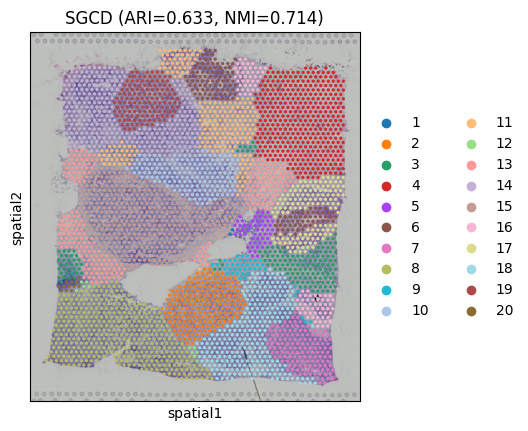

In [4]:
from sklearn import metrics
adata = adata[~pd.isnull(adata.obs['cluster'])]


# 计算 ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['cluster'])
adata.uns['ARI'] = ARI

# 计算 NMI
NMI = metrics.normalized_mutual_info_score(adata.obs['domain'], adata.obs['cluster'])
adata.uns['NMI'] = NMI

# 打印 ARI 和 NMI
print('ARI:', ARI)
print('NMI:', NMI)


#绘制空间聚类结果
sc.pl.spatial(adata,
              img_key="hires",
              color=[ "domain"],
              title=[ "SGCD (ARI=%.3f, NMI=%.3f)" % (ARI, NMI)],
              show=True)
